In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import time

#Web Scraping ดึงข้อมูลจาก หุ้น 6 ตัว (scc,cpall,advanc,kbank,ptt,aot) และ set index เพื่อสร้างโมเดลที่ใช้ราคาหุ้นเป็น feature เพื่อทำนาย set index

In [3]:
import bs4 as bs
import urllib.request

In [4]:
def pull_info_from_Settrade(stockName):
  data = stockName
  data = []
  for i in range (8):
    url = f'https://www.settrade.com/C04_02_stock_historical_p1.jsp?txtSymbol={stockName}&selectPage=2&max=15&offset={i*15}'
    source = urllib.request.urlopen(url).read()
    soup = bs.BeautifulSoup(source,'lxml')
    table = soup.table
    table_rows = table.find_all('tr')
    for tr in table_rows:
      td = tr.find_all('td')
      row = [i.text for i in td]
    #print(row)
      data.append(row)
  return data

In [5]:
def pull_info_from_web(urlName):
  url = urlName
  source = urllib.request.urlopen(url).read()
  soup = bs.BeautifulSoup(source,'lxml')
  table = soup.table
  table_rows = table.find_all('tr')
  for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
  return row

In [6]:
urlName = 'https://www.investing.com/commodities/gold-historical-data'

In [7]:
t0 = time.time()
#stock_list = ['scc','cpall','advanc','kbank','ptt','aot']
scc = pull_info_from_Settrade('scc')
cpall = pull_info_from_Settrade('cpall')
advanc = pull_info_from_Settrade('advanc')
kbank = pull_info_from_Settrade('kbank')
ptt = pull_info_from_Settrade('ptt')
aot = pull_info_from_Settrade('aot')
print(time.time() - t0)

76.47639632225037


In [8]:
def createDataFrame(data):
  df = pd.DataFrame(data,columns=['date','open','high','low','avg_price','close','change','%change','volume(x1000)','value(MB)','setIndex','%change'])
  df = df.mask(df.eq('None')).dropna() 
  #df['date'] = pd.to_datetime(df.date,format='%Y%m%d')
  df = df.set_index('date')

  for i in range (11):
    df.iloc[:,i] = df.iloc[:,i].str.replace('[^\d\.]','').astype('float')
  df = df.apply(pd.to_numeric)

  return df

def trim_X(df):
  df = df.iloc[:,[4]]
  return df

def trim_y(df):
  df = df.iloc[:,[9]]
  return df

def createandTrimX(data):
  df = createDataFrame(data)
  X = trim_X(df)
  return X

def createandTrimy(data):
  df = createDataFrame(data)
  y = trim_y(df)
  return y


In [9]:
df_scc = createandTrimX(scc)
y = createandTrimy(scc)
df_cpall = createandTrimX(cpall)
df_advanc = createandTrimX(advanc)
df_kbank = createandTrimX(kbank)
df_ptt = createandTrimX(ptt)
df_aot = createandTrimX(aot)

In [10]:
df_scc.rename(columns={'close':'scc'},inplace=True)
df_cpall.rename(columns={'close':'cpall'},inplace=True)
df_advanc.rename(columns={'close':'advanc'},inplace=True)
df_kbank.rename(columns={'close':'kbank'},inplace=True)
df_ptt.rename(columns={'close':'ptt'},inplace=True)
df_aot.rename(columns={'close':'aot'},inplace=True)

In [11]:
listofStock = [df_scc,df_cpall,df_advanc,df_kbank,df_ptt,df_aot]
X = pd.concat(listofStock, axis=1, sort=False)

In [12]:
X

,scc,cpall,advanc,kbank,ptt,aot
date,,,,,,
10/11/20,367.0,63.00,181.5,94.25,38.25,67.75
09/11/20,361.0,60.25,179.0,80.50,34.75,57.25
06/11/20,350.0,59.25,174.0,80.25,34.00,55.75
05/11/20,350.0,59.00,179.0,78.50,34.00,56.75
04/11/20,341.0,55.25,172.0,76.75,32.50,54.50
...,...,...,...,...,...,...
20/05/20,347.0,70.00,191.5,88.00,36.75,59.50
19/05/20,345.0,69.75,189.5,87.00,36.50,60.00
18/05/20,339.0,69.75,188.5,82.25,36.00,58.50


In [13]:
X.shape[1]

6

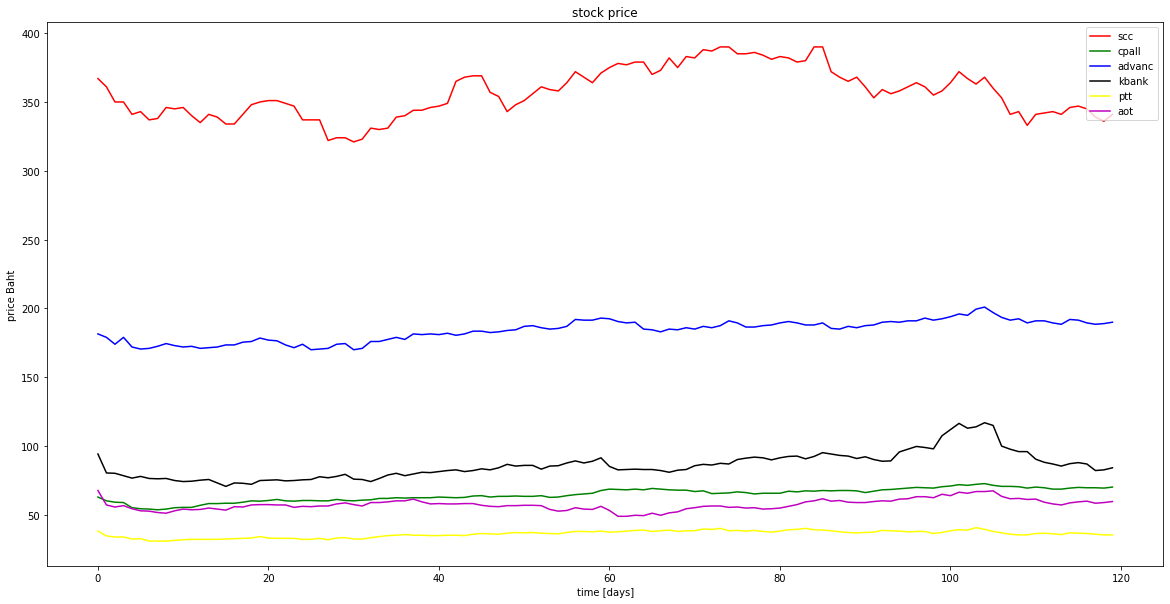

In [14]:
plt.figure(figsize=(20, 10));

plt.plot(X.iloc[:,0].values, color='red', label='scc')
plt.plot(X.iloc[:,1].values, color='green', label='cpall')
plt.plot(X.iloc[:,2].values, color='blue', label='advanc')
plt.plot(X.iloc[:,3].values, color='black', label='kbank')
plt.plot(X.iloc[:,4].values, color='yellow', label='ptt')
plt.plot(X.iloc[:,5].values, color='m', label='aot')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price Baht')
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.show()

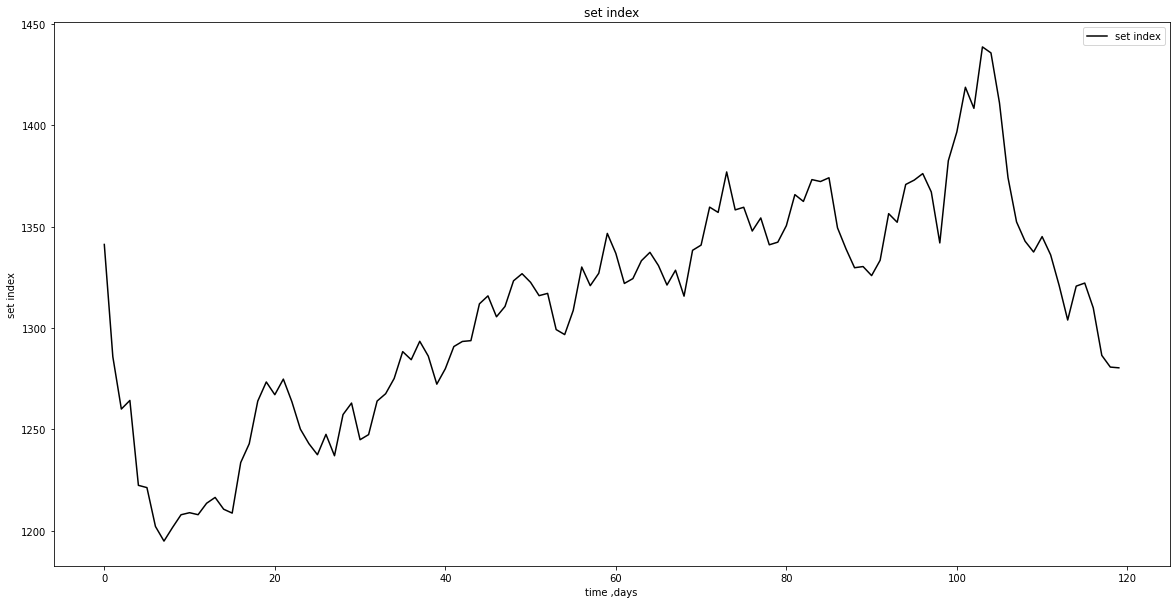

In [15]:
plt.figure(figsize=(20, 10));
plt.plot(y.values, color='black', label='set index')
plt.title('set index')
plt.xlabel('time ,days')
plt.ylabel('set index')
plt.legend(loc='best');

In [16]:
X_train = X.iloc[:X.shape[0]-20,:].values
X_test = X.iloc[X.shape[0]-20:,:].values
y_train = y.iloc[:y.shape[0]-20,:].values
y_test = y.iloc[y.shape[0]-20:,:].values

In [17]:
X_train.shape

(100, 6)

In [18]:
X_test.shape

(20, 6)

In [19]:
y_train.shape

(100, 1)

## model สำหรับทำนาย set index ด้วยราคาหุ้น 6 ตัว

In [20]:
import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [21]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [22]:
X_train.shape

(100, 6, 1)

In [23]:
y_train.shape

(100, 1)

In [24]:
model = Sequential()
model.add(LSTM(units = 1024, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 1024, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 1024, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 1024))
model.add(Dropout(0.2))
model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


history = model.fit(X_train, y_train, epochs = 350, batch_size = 8,validation_data=(X_test,y_test))

Epoch 1/350
13/13 [==============================] - 1s 112ms/step - loss: 1621178.2500 - val_loss: 1699668.2500
Epoch 2/350
13/13 [==============================] - 0s 24ms/step - loss: 1557915.5000 - val_loss: 1665304.7500
Epoch 3/350
13/13 [==============================] - 0s 24ms/step - loss: 1524691.3750 - val_loss: 1631060.8750
Epoch 4/350
13/13 [==============================] - 0s 24ms/step - loss: 1492212.7500 - val_loss: 1597536.2500
Epoch 5/350
13/13 [==============================] - 0s 24ms/step - loss: 1460872.1250 - val_loss: 1564861.0000
Epoch 6/350
13/13 [==============================] - 0s 24ms/step - loss: 1429465.6250 - val_loss: 1532890.6250
Epoch 7/350
13/13 [==============================] - 0s 24ms/step - loss: 1398764.5000 - val_loss: 1501563.0000
Epoch 8/350
13/13 [==============================] - 0s 24ms/step - loss: 1368110.2500 - val_loss: 1470786.7500
Epoch 9/350
13/13 [==============================] - 0s 24ms/step - loss: 1339423.8750 - val_loss: 1440

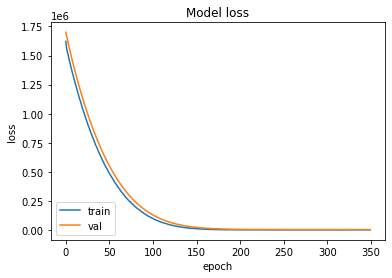

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [26]:
y_predict = model.predict(X_test)

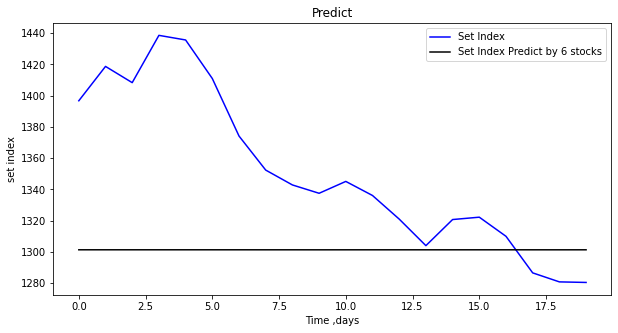

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, color='blue', label='Set Index')
plt.plot(y_predict, color='black', label='Set Index Predict by 6 stocks')
plt.title('Predict')
plt.xlabel('Time ,days')
plt.ylabel('set index')
plt.legend(loc='best')

## model สำหรับทำนาย set index ด้วยข้อมูลย้อนหลังของข้อมูล set index กำหนดกลุ่มข้อมูลย้อนหลังทีล่ะ 5 (5 -time steps) เป็น X ส่วนข้อมูลตัวที่ 6 เป็น y

In [28]:
y_ = y.reset_index()

In [29]:
training_set = y_.iloc[:120-20,[1]]
testing_set = y_.iloc[120-20:, [1]]

In [30]:
training_set.shape

(100, 1)

In [31]:
sc_ = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc_.fit_transform(training_set)

train_X = []
train_y = []

for i in range(5, 100):
  train_X.append(training_set_scaled[i-5:i, 0])
  train_y.append(training_set_scaled[i, 0])
train_X, train_y = np.array(train_X), np.array(train_y)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))

In [32]:
train_X.shape

(95, 5, 1)

In [33]:
train_y.shape

(95,)

In [34]:
dataset_train = y.iloc[:100, :]
dataset_test = y.iloc[100:, :]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 5:].values
inputs = inputs.reshape(-1,1)

inputs = sc_.fit_transform(inputs)
#inputs = sc.transform(inputs)
test_X = []
test_y = []
for i in range(5, 25):
    test_X.append(inputs[i-5:i, 0])
    test_y.append(inputs[i, 0])
test_X,test_y = np.array(test_X),np.array(test_y)
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))
print(test_X.shape)

(20, 5, 1)


In [35]:
inputs.shape

(25, 1)

In [36]:
test_X.shape

(20, 5, 1)

In [37]:
model_ = Sequential()
model_.add(LSTM(units = 1024, return_sequences = True, input_shape = (train_X.shape[1], 1)))
model_.add(Dropout(0.2))
model_.add(LSTM(units = 1024, return_sequences = True))
model_.add(Dropout(0.2))
model_.add(LSTM(units = 1024, return_sequences = True))
model_.add(Dropout(0.2))
model_.add(LSTM(units = 1024))
model_.add(Dropout(0.2))
model_.add(Dense(units = 1))

model_.compile(optimizer = 'adam', loss = 'mean_squared_error')

hist = model_.fit(train_X, train_y, epochs = 350, batch_size = 8,validation_data=(test_X,test_y))

Epoch 1/350
12/12 [==============================] - 1s 116ms/step - loss: 0.2015 - val_loss: 0.1643
Epoch 2/350
12/12 [==============================] - 0s 23ms/step - loss: 0.0322 - val_loss: 0.0717
Epoch 3/350
12/12 [==============================] - 0s 23ms/step - loss: 0.0255 - val_loss: 0.0682
Epoch 4/350
12/12 [==============================] - 0s 23ms/step - loss: 0.0355 - val_loss: 0.1305
Epoch 5/350
12/12 [==============================] - 0s 23ms/step - loss: 0.0269 - val_loss: 0.0675
Epoch 6/350
12/12 [==============================] - 0s 23ms/step - loss: 0.0161 - val_loss: 0.0565
Epoch 7/350
12/12 [==============================] - 0s 23ms/step - loss: 0.0177 - val_loss: 0.0678
Epoch 8/350
12/12 [==============================] - 0s 23ms/step - loss: 0.0151 - val_loss: 0.0560
Epoch 9/350
12/12 [==============================] - 0s 23ms/step - loss: 0.0128 - val_loss: 0.0539
Epoch 10/350
12/12 [==============================] - 0s 24ms/step - loss: 0.0124 - val_loss: 0.052

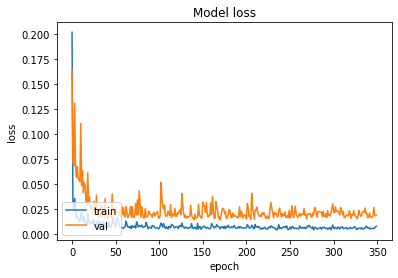

In [38]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [39]:
predict_y = model_.predict(test_X)
predict_y = sc_.inverse_transform(predict_y)

## เปรียบเทียบการทำนายของ model ทั้งสองแบบ

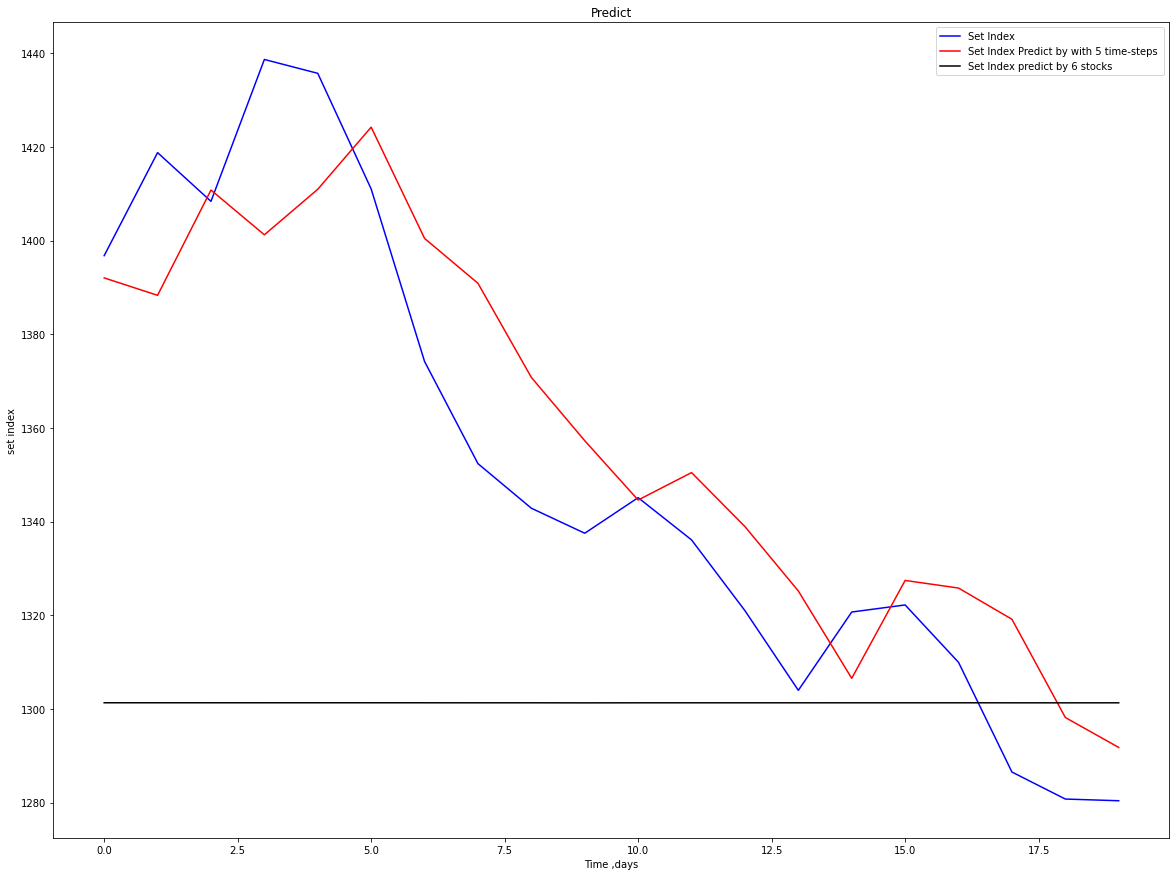

In [40]:
plt.figure(figsize=(20, 15))
plt.plot(y_test, color='blue', label='Set Index')
plt.plot(predict_y, color='red',  label='Set Index Predict by with 5 time-steps ')
plt.plot(y_predict, color='black', label='Set Index predict by 6 stocks')
plt.title('Predict')
plt.xlabel('Time ,days')
plt.ylabel('set index')
plt.legend(loc='best')